# 10339 - Catalysis: Homework \#5 Solutions
## Nitric Oxide Reduction: Volcano plot and steady-state approximation

Consider the nitric oxide reduction reaction:

$$2\text{NO}(g) + 2\text{H}_2(g) \rightleftharpoons \text{N}_2(g) + 2\text{H}_2\text{O}(g)$$

which we assume occurs via the elementary steps:

\begin{align}
1. \quad &\text{NO}(g) + * &\rightleftharpoons& \text{NO}* \notag \\
2. \quad &\text{H}_2(g) + 2* &\rightleftharpoons& \text{2H*} \notag \\
3. \quad &\text{NO}* + * &\rightleftharpoons& \text{N}* + \text{O*} \notag \\
4. \quad &2\text{N}* &\rightleftharpoons& \text{N2}(g) + 2* \notag \\
5. \quad &\text{O}* + \text{H}* &\rightleftharpoons& \text{OH}* + * \notag \\
6. \quad &\text{OH}* + \text{H}* &\rightleftharpoons& \text{H$_2$O}(g) + 2* \notag
\end{align}

Assume the reaction runs at 1000 K with $P_{NO} = P_{H_2} = 0.4$ bar and $P_{N_2} = P_{H_2O}$ = 0.1 bar. You may also employ the same assumptions used in HW1-3 for the enthalpy and entropy of gas-phase and adsorbed species. For simplicity, you may also assume that only NO* dissociation (reaction 3) or OH* formation (reaction 5) are rate-limiting.


## 1. 

Obtain the energetics for this reaction on the (211) surfaces of Pt, Cu, and Ag from CatApp. Make free energy diagrams for Pt, Cu, and Ag and discuss which you expect to be the best catalyst.


### Solution

Stoichiometrically, all steps occur twice except reaction 4, which happens once.  All ambiguous transition states were assumed to be adsorbed except for the transition state of reaction 1.  Since it didn't matter for the kinetics, we didn't comment on whether each ambiguous transition state was gaseous or adsorbed.  Pt(211) appears to be the best catalyst for this reaction because it seems to have the most direct path from reactants to products in terms of energies and have the lowest activation barriers.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from ase.db import connect
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pickle
import copy

# Connect to the CatApp database
catapp=connect('catapp.db')

def reaction(catapp,reverse=False,**kwargs):
    """Download reactions from CatApp. ab -> a + b if reverse=False
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            output : list
                Output is a list with the reaction, the surface, 
                energy of the reaction and the activation energy
    """
    output=[]
    for row in catapp.select(**kwargs):
        er=row.er
        ea=row.ea
        ea=np.max([0,er,ea])
        if reverse==True:
            er=-er
            ea+=er
            # The activation energy must be the largest
            ea=np.max([0,er,ea])
            react='{} + {} -> {}'.format(row.a,row.b,row.ab)
            surf=row.surface
        else:
            react='{} -> {} + {}'.format(row.ab,row.a,row.b)
            surf=row.surface
        output.append((react,surf,er,ea))
    return output
        
def reaction_dict(catapp,reverse=False,react_list=[],pd_react=None,**kwargs):
    """A wrapper that makes a dict of the data from CatApp
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            react_list : list of str
                A list of all the reactions (can be continued in a new function call)
            pd_react : dict
                A dictionary with the surfaces, energy differences and activation energies
                that can be continued in a new function call
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            pd_react : dict
                A dictionary with the surface, 
                energy of the reaction and the activation energy
            react_list : list
                A list of all the reactions
    """
    if pd_react is None:
        pd_react={'Surface':[],'E_diff':[],'Ea':[]}
    for r in reaction(catapp,reverse=reverse,**kwargs):
        react,surf,er,ea=list(r)
        pd_react['Surface'].append(surf)
        if react not in react_list:
            react_list.append(react)
        pd_react['E_diff'].append(er)
        pd_react['Ea'].append(ea)
    return pd_react,react_list
        
# Surfaces investigated
#surfaces=['Ru(211)','Rh(211)','Ni(211)','Pt(211)','Pd(211)','Cu(211)','Ag(211)']
surfaces=['Pt(211)','Cu(211)','Ag(211)']
pd_list=[]
react_list=[]

# The NO+*->NO* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'NO*','a':'NO', 'b':'*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The H2+2*->2H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The NO*+*->N*+O* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'NO*','a':'N*', 'b':'O*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The 2N*->N2+* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'N2','a':'N*','b':'N*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The O*+H*->OH*+* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'OH*','a':'O*','b':'H*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The OH*+H*->H2O+2* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2O','b':'OH*', 'a':'H*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# Show all the extracted data from CatApp
for p,pdf in enumerate(pd_list):
    print('\n',react_list[p])
    display(pdf)

# Show the energies and reactions there exist for all surfaces
pd_surf=pd.concat(pd_list,axis=1,keys=react_list,join='inner')
#pd_surf=pd_surf.loc[['Pt(211)','Ag(211)']]
display(pd_surf)
pickle.dump(pd_surf,open('HW5_ener_catapp.pkl','wb'))



 NO + * -> NO*


,E_diff,Ea
Surface,,
Pt(211),-1.885,0.0
Cu(211),-0.825,0.0
Ag(211),-0.165,0.0



 H2 -> H* + H*


,E_diff,Ea
Surface,,
Pt(211),-1.000,0.09
Cu(211),-0.118,0.68
Ag(211),0.554,0.99



 NO* -> N* + O*


,E_diff,Ea
Surface,,
Pt(211),0.61,2.00
Cu(211),-0.19,1.45
Ag(211),1.80,2.76



 N* + N* -> N2


,E_diff,Ea
Surface,,
Pt(211),-1.35,1.20
Cu(211),-2.65,1.49
Ag(211),-5.59,1.01



 O* + H* -> OH*


,E_diff,Ea
Surface,,
Pt(211),-0.458,0.780
Cu(211),-0.909,0.757
Ag(211),-1.895,0.414



 H* + OH* -> H2O


,E_diff,Ea
Surface,,
Pt(211),0.138,0.857
Cu(211),0.097,0.895
Ag(211),-0.769,0.620


NO + * -> NO*      H2 -> H* + H*       NO* -> N* + O*        \
               E_diff   Ea        E_diff    Ea         E_diff    Ea   
Surface                                                               
Pt(211)        -1.885  0.0        -1.000  0.09           0.61  2.00   
Cu(211)        -0.825  0.0        -0.118  0.68          -0.19  1.45   
Ag(211)        -0.165  0.0         0.554  0.99           1.80  2.76   

        N* + N* -> N2       O* + H* -> OH*        H* + OH* -> H2O         
               E_diff    Ea         E_diff     Ea          E_diff     Ea  
Surface                                                                   
Pt(211)         -1.35  1.20         -0.458  0.780           0.138  0.857  
Cu(211)         -2.65  1.49         -0.909  0.757           0.097  0.895  
Ag(211)         -5.59  1.01         -1.895  0.414          -0.769  0.620

In [2]:
# The reactions that will be plotted. Every second is the TS!!!
input_df={'Reactions':['NO + * -> NO*','[NO + * -> NO*]TS',
                       'NO + * -> NO*','[NO + * -> NO*]TS',
                       'H2 + 2* -> 2 H*','[H2 + 2* -> 2 H*]TS',
                       'H2 + 2* -> 2 H*','[H2 + 2* -> 2 H*]TS',
                       'NO* + * -> N* + O*','[NO* + * -> N* + O*]TS',
                       'NO* + * -> N* + O*','[NO* + * -> N* + O*]TS',
                       '2 N* -> N2 + 2*','[2 N* -> N2 + 2*]TS',
                       'O* + H* -> OH* + *','[O* + H* -> OH* + *]TS',
                       'O* + H* -> OH* + *','[O* + H* -> OH* + *]TS',
                       'OH* + H* -> H2O + 2*','[OH* + H* -> H2O + 2*]TS',
                       'OH* + H* -> H2O + 2*','[OH* + H* -> H2O + 2*]TS']}

#pd_surf=pd_surf.loc[['Pt(211)','Ag(211)','Ru(211)']]

# Get the reaction energies for each surface
for s,surf in enumerate(pd_surf.index):
    input_df[surf]=[]
    surf_keys=pd_surf.keys()
    k=0
    for r,react in enumerate(input_df['Reactions']):
        if input_df['Reactions'][r] in input_df['Reactions'][:r]:
            i=np.where(input_df['Reactions'][r]==np.array(input_df['Reactions'][:r]))[0][0]
            input_df[surf].append(input_df[surf][i])
        else:
            input_df[surf].append(pd_surf[surf_keys[k]][s])
            k+=1

# Show the energies for each surface (Same results as Problem 1.)
input_df=pd.DataFrame(input_df)
display(input_df)
# Save the energies
pickle.dump(input_df,open('HW5_energies.pkl','wb'))

,Reactions,Pt(211),Cu(211),Ag(211)
0,NO + * -> NO*,-1.885,-0.825,-0.165
1,[NO + * -> NO*]TS,0.000,0.000,0.000
2,NO + * -> NO*,-1.885,-0.825,-0.165
3,[NO + * -> NO*]TS,0.000,0.000,0.000
4,H2 + 2* -> 2 H*,-1.000,-0.118,0.554
5,[H2 + 2* -> 2 H*]TS,0.090,0.680,0.990
6,H2 + 2* -> 2 H*,-1.000,-0.118,0.554
7,[H2 + 2* -> 2 H*]TS,0.090,0.680,0.990
8,NO* + * -> N* + O*,0.610,-0.190,1.800
9,[NO* + * -> N* + O*]TS,2.000,1.450,2.760


,Reactions,Pt(211),Cu(211),Ag(211)
0,NO + * -> NO*,0.115,1.175,1.835
1,[NO + * -> NO*]TS,0.115,1.175,1.835
2,NO + * -> NO*,0.115,1.175,1.835
3,[NO + * -> NO*]TS,0.115,1.175,1.835
4,H2 + 2* -> 2 H*,1.000,1.882,2.554
5,[H2 + 2* -> 2 H*]TS,2.090,2.680,2.990
6,H2 + 2* -> 2 H*,1.000,1.882,2.554
7,[H2 + 2* -> 2 H*]TS,2.090,2.680,2.990
8,NO* + * -> N* + O*,0.610,-0.190,1.800
9,[NO* + * -> N* + O*]TS,2.000,1.450,2.760


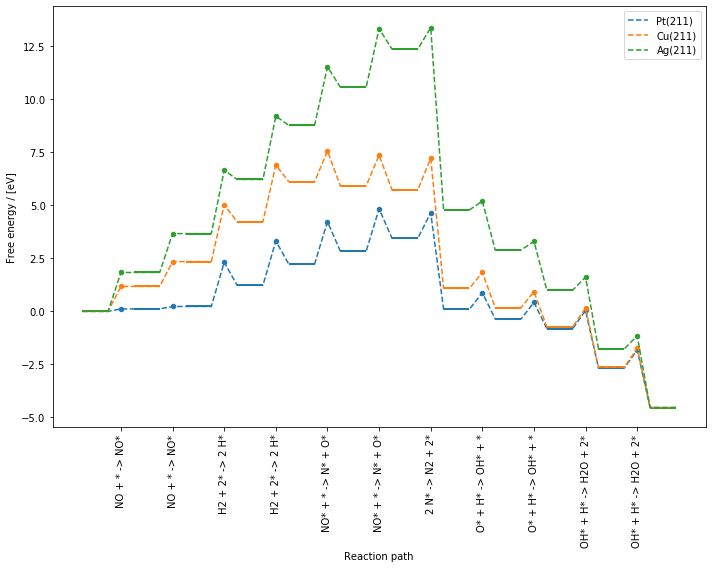

In [3]:
# initial energy
start=0
# Temperature
T=1000
# Entropy change for the reaction and for the TS
S_de=np.array([0.0-0.002]*4+[0.0-0.0]*2+[0.002-0.0]+[0.0-0.0]*2+[0.002-0.0]*2)
S_ea=np.array([0.002-0.002]*2+[0.0-0.002]*2+[0.0-0.0]*2+[0.0-0.0]+[0.0-0.0]*2+[0.0-0.0]*2)

# Use the results
input_df=pickle.load(open('HW5_energies.pkl','rb'))
# The reactions that will be plotted. Every second is the TS!!!
Reactions=copy.deepcopy(input_df['Reactions'])

# Add the entropy change
for key in input_df:
    if key!='Reactions':
        data=np.array(input_df[key])
        data[::2]=data[::2]-T*S_de
        data[1::2]=data[1::2]-T*S_ea
        max_ea=np.array([[0]*len(data[::2]),data[::2],data[1::2]])
        data[1::2]=np.max(max_ea,axis=0)
        input_df[key]=data
        
# Show the free energies for each surface  
input_df=pd.DataFrame(input_df)
display(input_df)
# Save the free energies
pickle.dump(input_df,open('HW5_free.pkl','wb'))


def energy_diagram_data(DE,Ea,start):
    'Convert the data so it can be used for the energy diagram'
    energy=start
    x=[]
    E=[]
    x_without=[]
    E_without=[]
    for i in range(len(DE)):
        x.extend([2*i,2*i+1])
        x_without.extend([2*i,2*i+1])
        E.extend([energy,energy])
        E_without.extend([energy])
        xin=2*i+1.5
        Ein=Ea[i]+energy
        x.append(xin)
        E.append(Ein)
        energy+=DE[i]
    x.extend([2*i+2,2*i+3])
    x_without.extend([2*i+2,2*i+3])
    E.extend([energy,energy])
    E_without.extend([energy])
    return x,E,x_without,E_without

def energy_diagram_plot(input_df,start=0,ylabel='Reaction energy',rotation=10):
    'Plot the energy diagram from the input data'
    plt.figure(figsize=(10,8))
    for key in input_df:
        if key=='Reactions':
            xticks=[2*i+1.5 for i in range(len(input_df[key][::2]))]
            plt.xticks(xticks,input_df[key][::2],rotation=rotation)
        else:
            DE=input_df[key][::2].tolist()
            Ea=input_df[key][1::2].tolist()
            x,E,x_without,E_without=energy_diagram_data(DE,Ea,start)
            p=plt.plot(x,E,label=key,linestyle='--')
            color=p[0].get_color()
            plt.scatter(x[2::3],E[2::3],color=color,s=20)
            plt.hlines(E_without,x_without[::2],x_without[1::2],color=color,linewidth=2)
    plt.xlabel('Reaction path')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.tight_layout()
    plt.show()
    pass
    
    
energy_diagram_plot(input_df,start=start,ylabel='Free energy / [eV]',rotation=90) 


## 2.

Use the quasi-equilibrium approximation in order to obtain an expression for the reaction rate as a function of rate/equilibrium constants and pressures. You should have two expressions, one for each potential rate-limiting step.


### Solution

For the rest of this homework, the following holds:
\begin{eqnarray}
    R_1 = 0 =& k_{1}P_{NO}\theta_*-k_{-1}\theta_{NO} \nonumber \\ 
    R_2 = 0 =& k_2P_{H_2}\theta_*^2 - k_{-2}\theta_H^2 \nonumber \\ 
    R_3 =& k_3\theta_{NO}\theta_* - k_{-3}\theta_N\theta_O \nonumber \\ 
    R_4 = 0 =& k_4\theta_N^2 - k_{-4}P_{N_2}\theta_*^2 \nonumber \\ 
    R_5 =& k_5\theta_O\theta_H - k_{-5}\theta_{OH}\theta_* \nonumber \\ 
    R_6 =0 =& k_6\theta_{OH}\theta_{H} - k_{-6}P_{H_2O}\theta_*^2 \nonumber
\end{eqnarray}
The quasi-equilibriated reactions 1, 2, 4, and 6 give:

\begin{eqnarray}
	\theta_{NO} =& K_1P_{NO}\theta_* \nonumber \\
	\theta_H =& \sqrt{K_2P_{H_2}}\theta_* \nonumber \\
	\theta_N =& \sqrt{\frac{P_{N_2}}{K_4}}\theta_* \nonumber \\
	\theta_{OH} =& \frac{P_{H_2O}}{K_6} \frac{1}{\sqrt{K_2P_{H_2}}}\theta_* \nonumber
\end{eqnarray}
If step 3 is limiting:
\begin{eqnarray}
	R_5 = 0 \nonumber \\
	\theta_O = \frac{\theta_{OH}}{K_5\theta_H}\theta_* = \frac{P_{H_2O}}{K_2 K_5 K_6 P_{H_2}}\theta_* \nonumber \\
	1 = \theta_* + \theta_{NO} + \theta_H + \theta_N + \theta_{OH} + \theta_O \nonumber \\
	\theta_* = \frac{1}{1 + K_1P_{NO} + \sqrt{K_2P_{H_2}} + \sqrt{\frac{P_{N_2}}{K_4}} + \frac{P_{H_2O}}{K_6\sqrt{K_2P_{H_2}}} + \frac{P_{H_2O}}{K_6K_5K_2P_{H_2}}} \notag \\
R=\frac{k_3 K_1 P_{NO}-k_{-3}\sqrt{\frac{P_{N_2}}{K_4}} \frac{P_{H_2O}}{K_2 K_5 K_6 P_{H_2}}}{\left(1 + K_1P_{NO} + \sqrt{K_2P_{H_2}} + \sqrt{\frac{P_{N_2}}{K_4}} + \frac{P_{H_2O}}{K_6\sqrt{K_2P_{H_2}}} + \frac{P_{H_2O}}{K_6K_5K_2P_{H_2}}\right)^2} \notag
\end{eqnarray}
Similarly, if step 5 is limiting: 
\begin{eqnarray}
	R_3 = 0 \nonumber \\
	\theta_O = \frac{K_3\theta_{NO}}{\theta_N}\theta_* = \frac{K_1 K_3 P_{NO}}{\sqrt{\frac{P_{N_2}}{K_4}}} \theta_* \nonumber \\
	1 = \theta_* + \theta_{NO} + \theta_H + \theta_N + \theta_{OH} + \theta_O \nonumber \\
  \theta_* = \frac{1}{1 + K_1P_{NO} + \sqrt{K_2P_{H_2}} + \sqrt{\frac{P_{N_2}}{K_4}} + \frac{P_{H_2O}}{K_6\sqrt{K_2P_{H_2}}} + \frac{K_3K_1P_{NO}}{\sqrt{\frac{P_{N_2}}{K_4}}}} \notag \\
R=\frac{ k_5 K_1 K_3 P_{NO} \sqrt{\frac{K_2 K_4 P_{H_2}}{P_{N_2}}} - k_{-5} \frac{P_{H_2O}}{K_6 \sqrt{K_2 P_{H_2}}} }{\left(1 + K_1P_{NO} + \sqrt{K_2P_{H_2}} + \sqrt{\frac{P_{N_2}}{K_4}} + \frac{P_{H_2O}}{K_6\sqrt{K_2P_{H_2}}} + \frac{K_3K_1P_{NO}}{\sqrt{\frac{P_{N_2}}{K_4}}}\right)^2} \notag
\end{eqnarray}



## 3.

Create scaling relations for the necessary energetics as a function of the sum of the NO* and O* binding energies, $E_{NO*+O*}=E_{NO*}+E_{O*}$. 

### Solution

There are 4 gas energies and 7 binding energies we need to define this problem.  Since we need one reference energy for each unique atomic species, I chose NO, H$_2$, and N$_2$ as my references:
\begin{eqnarray}
	E_{NO} =& 0 \nonumber \\
	E_{H_2} =& 0 \nonumber \\
	E_{N_2} =& 0 \nonumber \\
	E_{H_2O} = 0.5*\Delta E_{rxn} + E_{NO} + E_{H_2} - 0.5*E_{N_2} =& -3.3 \nonumber \\
	E_{NO*} =& E_{NO} + \Delta E_1 \nonumber \\
	E_{H*} =& \frac{1}{2}(E_{H_2} + \Delta E_2) \nonumber \\
	E_{OH*} =& -E_{H*} + E_{H_2O} - \Delta E_6 \nonumber \\
	E_{N*} =& \frac{1}{2}(E_{N_2}-\Delta E_4) \nonumber \\
	E_{O*} =& E_{OH*} - E_{H*} - \Delta E_5 \nonumber \\
	E_{N-O*} =& \Delta E_{a,3} + E_{NO*} \nonumber \\
	E_{O-H*} =& \Delta E_{a,5} + E_{O*} + E_{H*} \nonumber
\end{eqnarray}
Scaling relations for these 7 adsorbed species vs $E_{NO*+O*}$ are shown in the Figure below.  Note: your x-axis may be shifted depending on which gas phase species you chose as references, but that does not make the scaling any better or worse.


In [4]:
# All compounds that the energy is obtained for
compounds=['NO','NO*','[NO*]TS','H2','H*','[H*]TS','N*','O*','N-O*','N2','N-N*','OH*','H-O*','H2O','H2-O*']

# Reactants and products for all elementary reactions including TS formation
products=[['NO*'],['[NO*]TS'],['H*','H*'],['[H*]TS'],['N*','O*'],['N-O*'],['N2'],['N-N*'],['OH*'],['H-O*'],['H2O'],['H2-O*']]
reactants=[['NO'],['NO'],['H2'],['H2'],['NO*'],['NO*'],['N*','N*'],['N*','N*'],['O*','H*'],['O*','H*'],['OH*','H*'],['OH*','H*']]

energy_df=pickle.load(open('HW5_ener_catapp.pkl','rb'))
display(energy_df)
# The surfaces
metals=copy.deepcopy(energy_df.index)

# The descriptor used
descriptor='NO*'

def comp_energies_surf(compounds,reactants,products,pd_ener,ref,ref_txt,surfaces):
    'Compare energies by one reference for multiple surfaces'
    react=reactants+ref['Reactants']
    prod=products+ref['Products']
    pd_dict={'Surface':[],'Ref':[ref_txt]*len(surfaces)}
    for s,surf in enumerate(surfaces):
        energies=[pd_ener[key][s] for key in pd_ener.keys()]
        ener=energies+ref['Energies']
        coef_matrix=np.zeros((len(prod),len(compounds)))
        for row in range(len(coef_matrix)):
            for col in range(len(coef_matrix[0])):
                if compounds[col] in prod[row]:
                    coef_matrix[row,col]+=prod[row].count(compounds[col])
                if compounds[col] in react[row]:
                    coef_matrix[row,col]-=react[row].count(compounds[col])
        #coef_matrix[range(len(coef_matrix)),range(len(coef_matrix))]+=1e-10
        comp_energy=np.linalg.solve(coef_matrix,ener)
        pd_dict['Surface'].append(surf)
        for e in range(len(compounds)):
            if compounds[e] not in pd_dict:
                pd_dict[compounds[e]]=[]
            pd_dict[compounds[e]].append(round(comp_energy[e],2))
    return pd.DataFrame(pd_dict)

# Reference A (CO=0 eV , O2=0 eV)
ref={'Reactants':[[],[],[]],'Products':[['NO'],['H2'],['N2']],'Energies':[0,0,0]}
# Get the energies of all compounds compared to Reference A
pd_surf=comp_energies_surf(compounds,reactants,products,energy_df,ref,'NO=0 eV & H2=0 eV & N2=0 eV',metals)

# Make a linear combination descriptor of NO* and O*
pd_surf['NO*+O*']=pd_surf['NO*']+pd_surf['O*']

display(pd_surf)
pickle.dump(pd_surf,open('HW5_compound_energies.pkl','wb'))


NO + * -> NO*      H2 -> H* + H*       NO* -> N* + O*        \
               E_diff   Ea        E_diff    Ea         E_diff    Ea   
Surface                                                               
Pt(211)        -1.885  0.0        -1.000  0.09           0.61  2.00   
Cu(211)        -0.825  0.0        -0.118  0.68          -0.19  1.45   
Ag(211)        -0.165  0.0         0.554  0.99           1.80  2.76   

        N* + N* -> N2       O* + H* -> OH*        H* + OH* -> H2O         
               E_diff    Ea         E_diff     Ea          E_diff     Ea  
Surface                                                                   
Pt(211)         -1.35  1.20         -0.458  0.780           0.138  0.857  
Cu(211)         -2.65  1.49         -0.909  0.757           0.097  0.895  
Ag(211)         -5.59  1.01         -1.895  0.414          -0.769  0.620

,Surface,Ref,NO,NO*,[NO*]TS,H2,H*,[H*]TS,N*,O*,N-O*,N2,N-N*,OH*,H-O*,H2O,H2-O*,NO*+O*
0,Pt(211),NO=0 eV & H2=0 eV & N2=0 eV,0.0,-1.88,0.0,-0.0,-0.50,0.09,0.68,-1.95,0.12,-0.0,2.55,-2.91,-1.67,-3.27,-2.55,-3.83
1,Cu(211),NO=0 eV & H2=0 eV & N2=0 eV,-0.0,-0.82,-0.0,-0.0,-0.06,0.68,1.32,-2.34,0.62,-0.0,4.14,-3.31,-1.64,-3.27,-2.47,-3.16
2,Ag(211),NO=0 eV & H2=0 eV & N2=0 eV,-0.0,-0.16,-0.0,-0.0,0.28,0.99,2.80,-1.16,2.60,-0.0,6.60,-2.78,-0.47,-3.27,-1.88,-1.32


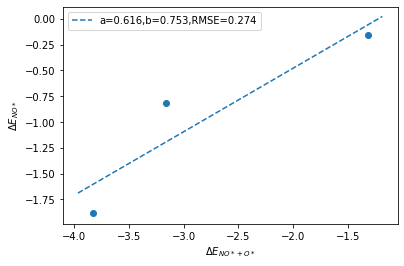

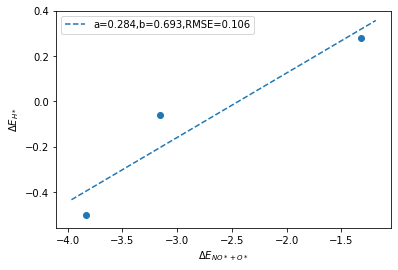

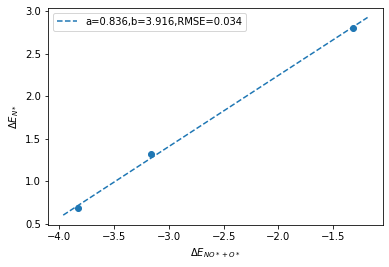

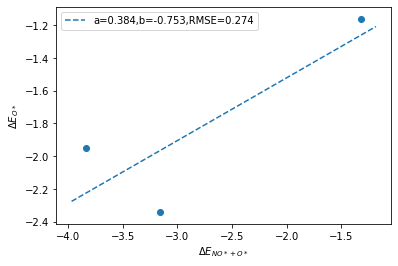

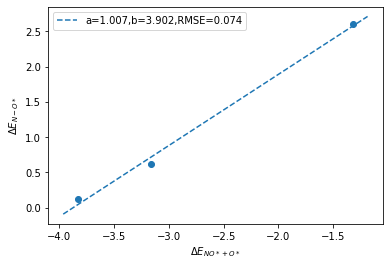

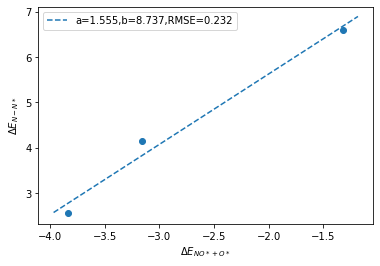

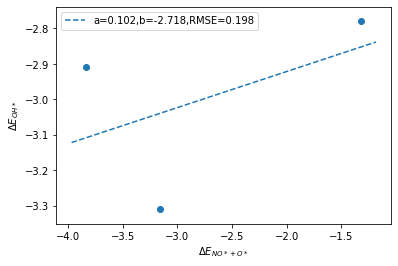

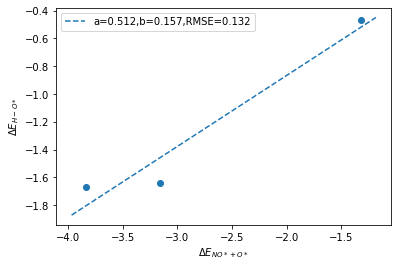

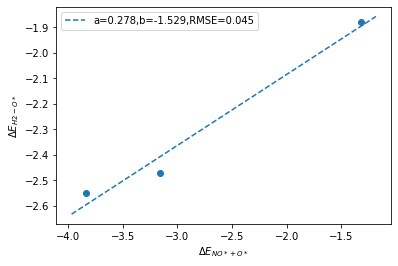

,Compounds,a,b,RMSE
0,NO*,0.615890,0.752682,0.273524
1,H*,0.283997,0.693339,0.105514
2,N*,0.836067,3.915904,0.033733
3,O*,0.384110,-0.752682,0.273524
4,N-O*,1.006749,3.902028,0.073740
5,N-N*,1.554792,8.736775,0.231666
6,OH*,0.101977,-2.717523,0.197879
7,H-O*,0.511604,0.157143,0.132155
8,H2-O*,0.278343,-1.528989,0.044995


In [5]:
# The descriptor used as a linear combination of NO* and O*
descriptor='NO*+O*'

# Compounds that are used for scaling relations
scaling_comp=['NO*','H*','N*','O*','N-O*','N-N*','OH*','H-O*','H2-O*']

# Load compound energies
pd_energy_surf=pickle.load(open('HW5_compound_energies.pkl','rb'))

# Plot the scaling relations
pd_scaling={'Compounds':[],'a':[],'b':[],'RMSE':[]}
for comp in scaling_comp:
    fig,ax=plt.subplots()
    x=pd_energy_surf[descriptor].values
    y=pd_energy_surf[comp].values
    ax.scatter(x,y)
    # Make linear fit
    a,b=np.polyfit(x,y,1) 
    x_axis=np.linspace(ax.get_xbound()[0],ax.get_xbound()[1],50)
    y_pred=a*x+b
    # Calculate root-mean-square error
    rmse=np.sqrt(np.mean((y-y_pred)**2))
    plt.plot(x_axis,a*x_axis+b,'--',label='a={:.3f},b={:.3f},RMSE={:.3f}'.format(a,b,rmse))
    ylab='$\Delta E_{'+comp+'}$'
    plt.ylabel(ylab)
    plt.xlabel('$\Delta E_{NO*+O*}$')
    ax.legend(loc=0)
    plt.show()
    # Save linear scaling  
    pd_scaling['Compounds'].append(comp)
    pd_scaling['a'].append(a)
    pd_scaling['b'].append(b)
    pd_scaling['RMSE'].append(rmse)

pd_scaling=pd.DataFrame(pd_scaling)
display(pd_scaling)
pickle.dump(pd_scaling,open('Linear_scaling_HW5.pkl','wb'))

## 4. 

Apply the scaling relations and rate expressions in order to create a "volcano plot" for NO reduction rate as a function of NO* and O* adsorption energies.


### Solution

Plugging the numbers in and plotting the rates, we see the volcano in the Figure below. Notice the fairly large scatter of actual rates around scaled rates. As we saw in the CO oxidation reaction, scaling N and O is not the best approximation.

In [6]:
# Partial pressures
pno,ph2,pn2,ph2o=0.4,0.4,0.1,0.1

# Entropies for each compound
S_compound={'NO':0.002,'NO*':0.0,'[NO*]TS':0.002,'H2':0.002,'H*':0.0,'[H*]TS':0.0,'N*':0.0,'O*':0.0,'N-O*':0.0,'N2':0.002,'N-N*':0.0,'OH*':0.0,'H-O*':0.0,'H2O':0.002,'H2-O*':0.0}

# Fixed energies that are independent of the surfaces
energi_fixed={'NO':0.00,'N2':0.00,'H2':0.00,'H2O':-3.27}

# Reactants and products for all elementary reactions including TS formation
products=[['NO*'],['H*','H*'],['N*','O*'],['N2'],['OH*'],['H2O']]
products_ts=[['[NO*]TS'],['[H*]TS'],['N-O*'],['N-N*'],['H-O*'],['H2-O*']]
reactants=[['NO'],['H2'],['NO*'],['N*','N*'],['O*','H*'],['OH*','H*']]


# Temperature
T=1000 # K

# Boltzmann constant
kB=8.617333262145*10**(-5) # eV/K
# Planck constant
h=4.135667696*10**(-15) # eV*s

kBT=kB*T
# Prefactor in TS theory
A=kBT/h

pd_ener=pickle.load(open('HW5_compound_energies.pkl','rb'))

def free_energy(pd_ener,fixed_e,reactants,products_ts,products):
    'Calculate the free energy for each surface'
    pd_dict={'Surface':pd_ener['Surface']}
    for c,comp in enumerate(pd_ener.keys()):
        pd_dict[comp]=pd_ener[comp]
    # Calculate reaction free energies
    for r in range(len(reactants)):
        pd_dict['G'+str(r+1)]=np.array([0]*len(pd_dict['Surface']))
        pd_dict['Ga'+str(r+1)]=np.array([0]*len(pd_dict['Surface']))
        Grea=0
        S_change=0
        Sa_change=0
        # Calculate the enthalpies and entropies for the product 
        for prod in products[r]:
            if prod in pd_dict.keys():
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+np.array([0]*len(pd_dict['Surface']))
            S_change=S_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the trainsition state 
        for prod in products_ts[r]:
            if prod in pd_dict.keys():
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+np.array([0]*len(pd_dict['Surface']))
            Sa_change=Sa_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the reactants 
        for rea in reactants[r]:
            if rea in pd_dict.keys():
                Grea=Grea+pd_dict[rea]
            else:
                Grea=Grea+np.array([0]*len(pd_dict['Surface']))  
            S_change=S_change-(-T*S_compound[rea])
            Sa_change=Sa_change-(-T*S_compound[rea])
        # Calculate the enthalpy change
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]-Grea
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]-Grea
        # The activation energy is the largest energy before the entropy is taking into account
        pd_dict['Ga'+str(r+1)]=np.max(np.array([pd_dict['G'+str(r+1)],pd_dict['Ga'+str(r+1)],[0]*len(pd_dict['Surface'])]),axis=0)
        # Free energy
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+S_change
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+Sa_change
    pd_dict=pd.DataFrame(pd_dict)
    return pd_dict


def rate_eq(Ga,G,A,kBT):
    """Calculate the forward and backsward reaction rate 
       and the equilibrium constant from activation free energy and free energy"""
    k=A*np.exp(-Ga/kBT)
    Ga_inv=Ga-G
    kinv=A*np.exp(-Ga_inv/kBT)
    K=np.exp(-G/kBT)
    return k,kinv,K

def R3(k3,k3i,K1,K2,K3,K4,K5,K6,pno,ph2,pn2,ph2o):
    'Rate of reaction 3'
    cov=(1+K1*pno+np.sqrt(K2*ph2)+np.sqrt(pn2/K4)+ph2o/(K6*np.sqrt(K2*ph2))+ph2o/(K6*K5*K2*ph2))
    return (k3*K1*pno-k3i*np.sqrt(pn2/K4)*ph2o/(K2*K5*K6*ph2))/(cov**2)

def R5(k5,k5i,K1,K2,K3,K4,K5,K6,pno,ph2,pn2,ph2o):
    'Rate of reaction 5'
    cov=(1+K1*pno+np.sqrt(K2*ph2)+np.sqrt(pn2/K4)+ph2o/(K6*np.sqrt(K2*ph2))+K1*K3*pno/np.sqrt(pn2/K4))
    return (k5*K1*K3*pno*np.sqrt((K2*K4*ph2)/pn2)-k5i*ph2o/(K6*np.sqrt(K2*ph2)))/cov**2


def rates_surf(pd_free,descriptor,A,kBT,pressures,rates_list):
    'Calculate the rates for each surface'
    pd_rates={'Surface':pd_free['Surface'],'Descriptor':descriptor}
    rate_constants=[]
    # Rate and equilibrium constants 
    for r in range(len(reactants)):
        pd_rates['k'+str(r+1)],pd_rates['k-'+str(r+1)],pd_rates['K'+str(r+1)]=rate_eq(pd_free['Ga'+str(r+1)],pd_free['G'+str(r+1)],A,kBT)
        rate_constants.append(np.array(pd_rates['K'+str(r+1)]))
    # Log10 rates
    for r in rates_list.keys():
        pd_rates['RDS'+r]=np.log10(rates_list[r](pd_rates['k'+r],pd_rates['k-'+r],*rate_constants,*pressures))
    # Reaction rate
    pd_rates['R']=np.min([pd_rates['RDS'+r] for r in rates_list.keys()],axis=0)
    
    pd_rates=pd.DataFrame(pd_rates)
    return pd_rates

rates_list={'3':R3,'5':R5}
pressures_p=[pno,ph2,pn2,ph2o]

pd_free_surf=free_energy(pd_ener,energi_fixed,reactants,products_ts,products)
display(pd_free_surf)

pd_rates_surf=rates_surf(pd_free_surf,pd_ener['NO*+O*'],A,kBT,pressures_p,rates_list)
display(pd_rates_surf)
pickle.dump(pd_rates_surf,open('Rates_surface_HW5.pkl','wb'))


,Surface,Ref,NO,NO*,[NO*]TS,H2,H*,[H*]TS,N*,O*,...,G2,Ga2,G3,Ga3,G4,Ga4,G5,Ga5,G6,Ga6
0,Pt(211),NO=0 eV & H2=0 eV & N2=0 eV,0.0,-1.88,0.0,-0.0,-0.50,0.09,0.68,-1.95,...,1.00,2.09,0.61,2.00,-3.36,1.19,-0.46,0.78,-1.86,0.86
1,Cu(211),NO=0 eV & H2=0 eV & N2=0 eV,-0.0,-0.82,-0.0,-0.0,-0.06,0.68,1.32,-2.34,...,1.88,2.68,-0.20,1.44,-4.64,1.50,-0.91,0.76,-1.90,0.90
2,Ag(211),NO=0 eV & H2=0 eV & N2=0 eV,-0.0,-0.16,-0.0,-0.0,0.28,0.99,2.80,-1.16,...,2.56,2.99,1.80,2.76,-7.60,1.00,-1.90,0.41,-2.77,0.62


,Surface,Descriptor,k1,k-1,K1,k2,k-2,K2,k3,k-3,...,K4,k5,k-5,K5,k6,k-6,K6,RDS3,RDS5,R
0,Pt(211),-3.83,2.083662e+13,8.386884e+13,2.484429e-01,610.507278,6.690661e+07,9.124768e-06,1.734886e+03,2.058428e+06,...,8.583308e+16,2.442307e+09,1.173552e+07,2.081124e+02,9.652016e+08,0.407972,2.365851e+09,2.152756,1.779080,1.779080
1,Cu(211),-3.16,2.083662e+13,1.844020e+19,1.129957e-06,0.648966,1.936443e+09,3.351329e-10,1.152250e+06,1.131334e+05,...,2.424213e+23,3.080320e+09,7.987257e+04,3.856543e+04,6.067739e+08,0.161231,3.763384e+09,-0.283349,-2.303129,-2.303129
2,Ag(211),-1.32,2.083662e+13,3.908581e+22,5.330993e-10,0.017778,1.418152e+11,1.253626e-13,2.564717e-01,3.024407e+08,...,2.005923e+38,1.788620e+11,4.752692e+01,3.763384e+09,1.563741e+10,0.000171,9.124006e+13,-10.262093,3.593082,-10.262093


,Descriptor,NO,N2,H2,H2O,NO*,H*,N*,O*,N-O*,...,G2,Ga2,G3,Ga3,G4,Ga4,G5,Ga5,G6,Ga6
0,-8.000,0.0,0.0,0.0,-3.27,-4.174439,-1.578640,-2.772628,-3.825561,-4.151965,...,-1.157279,2.000000,-2.423751,0.022474,3.545256,5.545256,1.870859,1.870859,-0.158019,1.841981
1,-7.999,0.0,0.0,0.0,-3.27,-4.173823,-1.578356,-2.771792,-3.825177,-4.150958,...,-1.156711,2.000000,-2.423146,0.022865,3.543584,5.543584,1.870293,1.870293,-0.158405,1.841595
2,-7.998,0.0,0.0,0.0,-3.27,-4.173207,-1.578072,-2.770956,-3.824793,-4.149951,...,-1.156143,2.000000,-2.422542,0.023256,3.541912,5.541912,1.869727,1.869727,-0.158791,1.841209
3,-7.997,0.0,0.0,0.0,-3.27,-4.172591,-1.577788,-2.770120,-3.824409,-4.148945,...,-1.155575,2.000000,-2.421938,0.023646,3.540240,5.540240,1.869161,1.869161,-0.159176,1.840824
4,-7.996,0.0,0.0,0.0,-3.27,-4.171975,-1.577504,-2.769284,-3.824025,-4.147938,...,-1.155007,2.000000,-2.421334,0.024037,3.538568,5.538568,1.868595,1.868595,-0.159562,1.840438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,0.996,0.0,0.0,0.0,-3.27,1.366109,0.976201,4.748627,-0.370109,4.904751,...,3.952402,3.952402,3.012409,3.538642,-11.497253,0.788095,-3.222045,0.060608,-3.630248,0.387994
8997,0.997,0.0,0.0,0.0,-3.27,1.366725,0.976485,4.749463,-0.369725,4.905757,...,3.952970,3.952970,3.013013,3.539033,-11.498925,0.787978,-3.222611,0.060451,-3.630634,0.387886
8998,0.998,0.0,0.0,0.0,-3.27,1.367341,0.976769,4.750299,-0.369341,4.906764,...,3.953538,3.953538,3.013617,3.539424,-11.500597,0.787861,-3.223177,0.060295,-3.631020,0.387779
8999,0.999,0.0,0.0,0.0,-3.27,1.367957,0.977053,4.751135,-0.368957,4.907771,...,3.954106,3.954106,3.014222,3.539814,-11.502270,0.787743,-3.223744,0.060138,-3.631406,0.387671


,Descriptor,k1,k-1,K1,k2,k-2,K2,k3,k-3,K3,...,K4,k5,k-5,K5,k6,k-6,K6,RDS3,RDS5,R
0,-8.000,2.083662e+13,2.291600e+02,9.092609e+10,1.734886e+03,2.551757e-03,6.798789e+05,1.605328e+13,9.781327e+00,1.641217e+12,...,1.357363e-18,7.764459e+03,2.083662e+13,3.726353e-10,1.085549e+04,1.734886e+03,6.257178e+00,2.638357,-7.735050,-7.735050
1,-7.999,2.083662e+13,2.308037e+02,9.027855e+10,1.734886e+03,2.568632e-03,6.754124e+05,1.598063e+13,9.805583e+00,1.629748e+12,...,1.383958e-18,7.815637e+03,2.083662e+13,3.750914e-10,1.090422e+04,1.734886e+03,6.285268e+00,2.639508,-7.731692,-7.731692
2,-7.998,2.083662e+13,2.324592e+02,8.963562e+10,1.734886e+03,2.585619e-03,6.709751e+05,1.590831e+13,9.829899e+00,1.618360e+12,...,1.411075e-18,7.867152e+03,2.083662e+13,3.775637e-10,1.095317e+04,1.734886e+03,6.313483e+00,2.640658,-7.728334,-7.728334
3,-7.997,2.083662e+13,2.341265e+02,8.899726e+10,1.734886e+03,2.602717e-03,6.665671e+05,1.583632e+13,9.854275e+00,1.607051e+12,...,1.438724e-18,7.919007e+03,2.083662e+13,3.800524e-10,1.100234e+04,1.734886e+03,6.341825e+00,2.641809,-7.724976,-7.724976
4,-7.996,2.083662e+13,2.358058e+02,8.836346e+10,1.734886e+03,2.619929e-03,6.621880e+05,1.576465e+13,9.878711e+00,1.595821e+12,...,1.466914e-18,7.971203e+03,2.083662e+13,3.825574e-10,1.105173e+04,1.734886e+03,6.370294e+00,2.642959,-7.721618,-7.721618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,0.996,2.716074e+06,2.502555e+23,1.085321e-17,2.509570e-07,2.083662e+13,1.204404e-20,3.053919e-05,4.642267e+10,6.578507e-16,...,8.782253e+57,1.031280e+13,5.956397e-04,1.731382e+16,2.309000e+11,1.168909e-07,1.975346e+18,-21.877524,-0.218394,-21.877524
8997,0.997,2.696731e+06,2.502555e+23,1.077591e-17,2.493083e-07,2.083662e+13,1.196491e-20,3.040098e-05,4.653779e+10,6.532537e-16,...,8.954330e+57,1.033155e+13,5.928150e-04,1.742794e+16,2.311886e+11,1.165140e-07,1.984213e+18,-21.882598,-0.220969,-21.882598
8998,0.998,2.677526e+06,2.502555e+23,1.069917e-17,2.476704e-07,2.083662e+13,1.188631e-20,3.026341e-05,4.665319e+10,6.486888e-16,...,9.129779e+57,1.035033e+13,5.900037e-04,1.754282e+16,2.314775e+11,1.161382e-07,1.993120e+18,-21.887672,-0.223544,-21.887672
8999,0.999,2.658458e+06,2.502555e+23,1.062298e-17,2.460433e-07,2.083662e+13,1.180822e-20,3.012645e-05,4.676888e+10,6.441558e-16,...,9.308666e+57,1.036914e+13,5.872058e-04,1.765845e+16,2.317668e+11,1.157637e-07,2.002068e+18,-21.892746,-0.226119,-21.892746


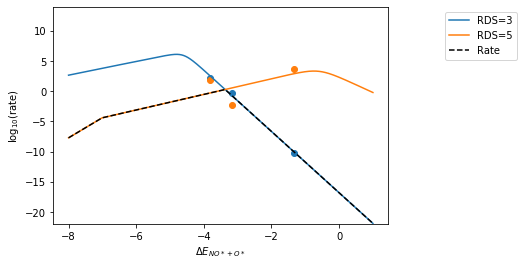

In [7]:
# The descriptor O* range
descriptor=np.linspace(-8,1,9001)


def free_energy_descriptor(descriptor,pd_scaling,fixed_e,reactants,products_ts,products):
    'Calculate the free energy from a descriptor with linear relations'
    # Calculate enthalpies
    pd_dict={'Descriptor':descriptor}
    # Use the fixed energies
    for comp in fixed_e.keys():
        pd_dict[comp]=np.array([fixed_e[comp]]*len(descriptor))
    # Calculate O*, CO*, O-O* and O-CO* from the linear scaling relations
    for c,comp in enumerate(pd_scaling['Compounds']):
        pd_dict[comp]=pd_scaling['a'][c]*descriptor+pd_scaling['b'][c]
    # Calculate reaction free energies
    for r in range(len(reactants)):
        pd_dict['G'+str(r+1)]=np.array([0]*len(descriptor))
        pd_dict['Ga'+str(r+1)]=np.array([0]*len(descriptor))
        Grea=0
        S_change=0
        Sa_change=0
        # Calculate the enthalpies and entropies for the product 
        for prod in products[r]:
            if prod in pd_dict.keys():
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+np.array([0]*len(descriptor))
            S_change=S_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the trainsition state 
        for prod in products_ts[r]:
            if prod in pd_dict.keys():
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+np.array([0]*len(descriptor))
            Sa_change=Sa_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the reactants 
        for rea in reactants[r]:
            if rea in pd_dict.keys():
                Grea=Grea+pd_dict[rea]
            else:
                Grea=Grea+np.array([0]*len(descriptor))  
            S_change=S_change-(-T*S_compound[rea])
            Sa_change=Sa_change-(-T*S_compound[rea])
        # Calculate the enthalpy change
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]-Grea
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]-Grea
        # The activation energy is the largest energy before the entropy is taking into account
        pd_dict['Ga'+str(r+1)]=np.max(np.array([pd_dict['G'+str(r+1)],pd_dict['Ga'+str(r+1)],[0]*len(descriptor)]),axis=0)
        # Free energy
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+S_change
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+Sa_change
        # Important extra line so that the activation free energy is the largest
        #pd_dict['Ga'+str(r+1)]=np.max(np.array([pd_dict['G'+str(r+1)],pd_dict['Ga'+str(r+1)],[0]*len(descriptor)]),axis=0)

    pd_dict=pd.DataFrame(pd_dict)
    return pd_dict

def rates_descriptor(descriptor,pd_free,A,kBT,pressures,rates_list):
    'Calculate the rates for each descriptor value'
    pd_rates={'Descriptor':descriptor}
    rate_constants=[]
    # Rate and equilibrium constants 
    for r in range(len(reactants)):
        pd_rates['k'+str(r+1)],pd_rates['k-'+str(r+1)],pd_rates['K'+str(r+1)]=rate_eq(pd_free['Ga'+str(r+1)],pd_free['G'+str(r+1)],A,kBT)
        rate_constants.append(np.array(pd_rates['K'+str(r+1)]))
    # Log10 rates
    for r in rates_list.keys():
        pd_rates['RDS'+r]=np.log10(rates_list[r](pd_rates['k'+r],pd_rates['k-'+r],*rate_constants,*pressures))
    # Reaction rate
    pd_rates['R']=np.min([pd_rates['RDS'+r] for r in rates_list.keys()],axis=0)
    
    pd_rates=pd.DataFrame(pd_rates)
    return pd_rates

rates_list={'3':R3,'5':R5}
pressures_p=[pno,ph2,pn2,ph2o]
    
# Enthalpies from linear scaling relations
pd_scaling=pickle.load(open('Linear_scaling_HW5.pkl','rb'))

pd_free=free_energy_descriptor(descriptor,pd_scaling,energi_fixed,reactants,products_ts,products)
display(pd_free)

pd_rates=rates_descriptor(descriptor,pd_free,A,kBT,pressures_p,rates_list)
display(pd_rates)
pickle.dump(pd_rates,open('Rates_descriptor_HW5.pkl','wb'))


# Plot the volcano
fig=plt.figure()
for r in rates_list.keys():
    plt.plot(pd_rates['Descriptor'],pd_rates['RDS'+r],label='RDS='+r)
    plt.scatter(pd_rates_surf['Descriptor'],pd_rates_surf['RDS'+r])
plt.plot(pd_rates['Descriptor'],pd_rates['R'],'k--',label='Rate')  

plt.ylabel('log$_{10}$(rate)')
plt.xlabel('$\Delta E_{NO*+O*}$')
plt.legend(bbox_to_anchor=(1.4,1))
plt.ylim(-22,14)
plt.show()

*Hint: The procedures for problems 1-4 are very similar to the ones you applied in HW1-3 for the CO oxidation reaction.*

## 5. 

Use the steady-state approximation for adsorbed oxygen ($\frac{\partial \theta_O}{\partial t} = 0$) in order to obtain an expression for the reaction rate as a function of rate/equilibrium constants and pressures. You may assume that reactions not involving the formation of adsorbed oxygen are equilibrated.

### Solution

Instead of setting either step 3 or 5 to equilibrium, we solve both simulatneously under the given constraint.

\begin{eqnarray}
	&\frac{\partial \theta_O}{\partial t} = 0 = R_3 - R_5 \nonumber \\
	&0 =  k_3\theta_{NO}\theta_* - k_{-3}\theta_N\theta_O - (k_5\theta_O\theta_H - k_{-5}\theta_{OH}\theta_*) \nonumber \\
	&k_5\theta_O\theta_H - k_{-5}\theta_{OH}\theta_* = k_3\theta_{NO}\theta_* - k_{-3}\theta_N\theta_O \nonumber \\
	&k_5\theta_O\theta_H + k_{-3}\theta_N\theta_O = k_3\theta_{NO}\theta_* + k_{-5}\theta_{OH}\theta_* \nonumber \\
	&\theta_O = \frac{k_3\theta_{NO} + k_{-5}\theta_{OH}}{k_5\theta_H + k_{-3}\theta_N}\theta_* \nonumber \\
	&\theta_O = \frac{k_3K_1P_{NO} + k_{-5}\frac{P_{H_2O}}{K_6} \frac{1}{\sqrt{K_2P_{H_2}}}}{k_5\sqrt{K_2P_{H_2}} + k_{-3}\sqrt{\frac{P_{N_2}}{K_4}}}\theta_* \nonumber \\
	&1 = \theta_* + \theta_{NO} + \theta_H + \theta_N + \theta_{OH} + \theta_O \nonumber \\
	&\theta_* = \frac{1}{1 + K_1P_{NO} + \sqrt{K_2P_{H_2}} + \sqrt{\frac{P_{N_2}}{K_4}} + \frac{P_{H_2O}}{K_6\sqrt{K_2P_{H_2}}} + \frac{k_3K_1P_{NO} + k_{-5}\frac{P_{H_2O}}{K_6} \frac{1}{\sqrt{K_2P_{H_2}}}}{k_5\sqrt{K_2P_{H_2}} + k_{-3}\sqrt{\frac{P_{N_2}}{K_4}}}} \notag \\
&R=\frac{ k_3 K_1 P_{NO} - k_{-3}\sqrt{\frac{P_{N_2}}{K_4}} \frac{k_3K_1P_{NO} + k_{-5}\frac{P_{H_2O}}{K_6} \frac{1}{\sqrt{K_2P_{H_2}}}}{k_5\sqrt{K_2P_{H_2}} + k_{-3}\sqrt{\frac{P_{N_2}}{K_4}}}\theta_*}{\left(1 + K_1P_{NO} + \sqrt{K_2P_{H_2}} + \sqrt{\frac{P_{N_2}}{K_4}} + \frac{P_{H_2O}}{K_6\sqrt{K_2P_{H_2}}} + \frac{k_3K_1P_{NO} + k_{-5}\frac{P_{H_2O}}{K_6} \frac{1}{\sqrt{K_2P_{H_2}}}}{k_5\sqrt{K_2P_{H_2}} + k_{-3}\sqrt{\frac{P_{N_2}}{K_4}}}\right)^2} \notag
\end{eqnarray}



*Hint: The solution is analytical, and the math works out very nicely if done properly. This is rarely the case with the steady-state approximation, hence it is normally implemented using a numerical solution.*

## 6.

Use the scaling relations and the steady-state rate expression in order to create a steady-state "volcano plot", and compare this to the volcano plot you obtained for the quasi-equilibrium approximation in problem 4. Briefly discuss the differences between these two plots in terms of rate-limiting steps and surface coverages. Which approximation is more accurate? Based on this analysis, which catalyst is the best for this reaction? 


### Solutions

Plugging in the reaction conditions and energies again, but this time to the steady state solution, we arrive at the solution. The steady state solution in part 5 generally has coverages of intermediates that lie somewhere between the two extremes of step 3 being rate-determining and step 5 being rate-determining. Since neither step 3 nor step 5 are fully equilibriated, the solution ends up being a sort of middle ground between the two extremes. The steady state solution is actually more accurate, as it uses fewer assumptions about which steps are in equilibrium. If we used no assumptions about rate-limiting steps, we would have to use a numerical method to get the full solution.  Pt and Pd are the best metals for this reaction depending on if you trust the scaling more (Pt is closer to the peak of the steady state solution) or if you trust the actual points more (Pd shows a higher rate).

,Descriptor,k1,k-1,K1,k2,k-2,K2,k3,k-3,K3,...,k5,k-5,K5,k6,k-6,K6,RDS3,RDS5,R,SS
0,-8.000,2.083662e+13,2.291600e+02,9.092609e+10,1.734886e+03,2.551757e-03,6.798789e+05,1.605328e+13,9.781327e+00,1.641217e+12,...,7.764459e+03,2.083662e+13,3.726353e-10,1.085549e+04,1.734886e+03,6.257178e+00,2.638357,-7.735050,-7.735050,-7.734389
1,-7.999,2.083662e+13,2.308037e+02,9.027855e+10,1.734886e+03,2.568632e-03,6.754124e+05,1.598063e+13,9.805583e+00,1.629748e+12,...,7.815637e+03,2.083662e+13,3.750914e-10,1.090422e+04,1.734886e+03,6.285268e+00,2.639508,-7.731692,-7.731692,-7.731023
2,-7.998,2.083662e+13,2.324592e+02,8.963562e+10,1.734886e+03,2.585619e-03,6.709751e+05,1.590831e+13,9.829899e+00,1.618360e+12,...,7.867152e+03,2.083662e+13,3.775637e-10,1.095317e+04,1.734886e+03,6.313483e+00,2.640658,-7.728334,-7.728334,-7.727658
3,-7.997,2.083662e+13,2.341265e+02,8.899726e+10,1.734886e+03,2.602717e-03,6.665671e+05,1.583632e+13,9.854275e+00,1.607051e+12,...,7.919007e+03,2.083662e+13,3.800524e-10,1.100234e+04,1.734886e+03,6.341825e+00,2.641809,-7.724976,-7.724976,-7.724293
4,-7.996,2.083662e+13,2.358058e+02,8.836346e+10,1.734886e+03,2.619929e-03,6.621880e+05,1.576465e+13,9.878711e+00,1.595821e+12,...,7.971203e+03,2.083662e+13,3.825574e-10,1.105173e+04,1.734886e+03,6.370294e+00,2.642959,-7.721618,-7.721618,-7.720928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,0.996,2.716074e+06,2.502555e+23,1.085321e-17,2.509570e-07,2.083662e+13,1.204404e-20,3.053919e-05,4.642267e+10,6.578507e-16,...,1.031280e+13,5.956397e-04,1.731382e+16,2.309000e+11,1.168909e-07,1.975346e+18,-21.877524,-0.218394,-21.877524,-21.877524
8997,0.997,2.696731e+06,2.502555e+23,1.077591e-17,2.493083e-07,2.083662e+13,1.196491e-20,3.040098e-05,4.653779e+10,6.532537e-16,...,1.033155e+13,5.928150e-04,1.742794e+16,2.311886e+11,1.165140e-07,1.984213e+18,-21.882598,-0.220969,-21.882598,-21.882598
8998,0.998,2.677526e+06,2.502555e+23,1.069917e-17,2.476704e-07,2.083662e+13,1.188631e-20,3.026341e-05,4.665319e+10,6.486888e-16,...,1.035033e+13,5.900037e-04,1.754282e+16,2.314775e+11,1.161382e-07,1.993120e+18,-21.887672,-0.223544,-21.887672,-21.887672
8999,0.999,2.658458e+06,2.502555e+23,1.062298e-17,2.460433e-07,2.083662e+13,1.180822e-20,3.012645e-05,4.676888e+10,6.441558e-16,...,1.036914e+13,5.872058e-04,1.765845e+16,2.317668e+11,1.157637e-07,2.002068e+18,-21.892746,-0.226119,-21.892746,-21.892746


,Surface,Descriptor,k1,k-1,K1,k2,k-2,K2,k3,k-3,...,k5,k-5,K5,k6,k-6,K6,RDS3,RDS5,R,SS
0,Pt(211),-3.83,2.083662e+13,8.386884e+13,2.484429e-01,610.507278,6.690661e+07,9.124768e-06,1.734886e+03,2.058428e+06,...,2.442307e+09,1.173552e+07,2.081124e+02,9.652016e+08,0.407972,2.365851e+09,2.152756,1.779080,1.779080,2.152727
1,Cu(211),-3.16,2.083662e+13,1.844020e+19,1.129957e-06,0.648966,1.936443e+09,3.351329e-10,1.152250e+06,1.131334e+05,...,3.080320e+09,7.987257e+04,3.856543e+04,6.067739e+08,0.161231,3.763384e+09,-0.283349,-2.303129,-2.303129,-0.283361
2,Ag(211),-1.32,2.083662e+13,3.908581e+22,5.330993e-10,0.017778,1.418152e+11,1.253626e-13,2.564717e-01,3.024407e+08,...,1.788620e+11,4.752692e+01,3.763384e+09,1.563741e+10,0.000171,9.124006e+13,-10.262093,3.593082,-10.262093,-10.262093


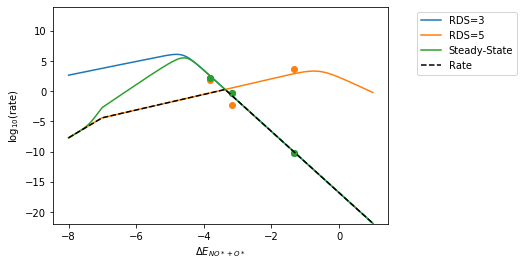

In [8]:
pressures_p=[pno,ph2,pn2,ph2o]

def steady_state(k3,k3i,k5,k5i,K1,K2,K3,K4,K5,K6,pno,ph2,pn2,ph2o):
    'Rate by using the steady-state approximation for O*'
    lambda_o=(k3*K1*pno+k5i*ph2o/(K6*np.sqrt(K2*ph2)))/(k5*np.sqrt(K2*ph2)+k3i*np.sqrt(pn2/K4))
    cov=(1+K1*pno+np.sqrt(K2*ph2)+np.sqrt(pn2/K4)+ph2o/(K6*np.sqrt(K2*ph2))+lambda_o)
    return (k3*K1*pno-k3i*np.sqrt(pn2/K4)*lambda_o)/(cov**2)

# Load the rates and equilibrium constants
pd_rates=pickle.load(open('Rates_descriptor_HW5.pkl','rb'))
# Calculate the rate from the steady-state approximation and scaling relations
pd_rates['SS']=np.log10(steady_state(pd_rates['k3'],pd_rates['k-3'],pd_rates['k5'],pd_rates['k-5'],*[pd_rates['K'+str(i)] for i in range(1,7)],*pressures_p))
display(pd_rates)

pd_rates_surf=pickle.load(open('Rates_surface_HW5.pkl','rb'))
pd_rates_surf['SS']=np.log10(steady_state(pd_rates_surf['k3'],pd_rates_surf['k-3'],pd_rates_surf['k5'],pd_rates_surf['k-5'],*[pd_rates_surf['K'+str(i)] for i in range(1,7)],*pressures_p))
display(pd_rates_surf)


# Plot the volcano
fig=plt.figure()
for r in rates_list.keys():
    plt.plot(pd_rates['Descriptor'],pd_rates['RDS'+r],label='RDS='+r)
    plt.scatter(pd_rates_surf['Descriptor'],pd_rates_surf['RDS'+r])
plt.plot(pd_rates['Descriptor'],pd_rates['SS'],label='Steady-State')
plt.scatter(pd_rates_surf['Descriptor'],pd_rates_surf['SS'])
plt.plot(pd_rates['Descriptor'],pd_rates['R'],'k--',label='Rate')
plt.ylabel('log$_{10}$(rate)')
plt.xlabel('$\Delta E_{NO*+O*}$')
plt.legend(bbox_to_anchor=(1.4,1))
plt.ylim(-22,14)
plt.show()